In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from aif360.sklearn.preprocessing import ReweighingMeta
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio,average_odds_error,generalized_fnr,generalized_fpr,difference
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds,PostProcessingMeta

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\bo.pei\softwares\Anaconda\Install2020\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bo.pei\softwares\Anaconda\Install2020\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\bo.pei\softwares\Anaconda\Install2020\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
X,y,sample_weight=fetch_adult()

In [3]:
#格式化数据，（1）将不同的protected attributes 用0,1表示；（2）将label用0（<=50K）,1(>=50K)表示
X.index=pd.MultiIndex.from_arrays(X.index.codes,names=X.index.names)
y.index=pd.MultiIndex.from_arrays(y.index.codes,names=y.index.names)
y=pd.Series(y.factorize(sort=True)[0],index=y.index)

In [4]:
(X_train,X_test,y_train,y_test)=train_test_split(X,y,train_size=0.7,random_state=1234567)

In [5]:
y_train

       race  sex
30149  1     1      0
12028  1     0      1
36374  1     1      1
8055   1     1      0
38108  1     1      0
                   ..
3198   1     1      0
41989  1     1      1
42370  1     1      1
29131  1     1      0
17287  0     1      0
Length: 31655, dtype: int64

In [6]:
# column transformer
ohe=make_column_transformer((OneHotEncoder(sparse=False),X_train.dtypes=='category'),
                           remainder="passthrough")
X_train=pd.DataFrame(ohe.fit_transform(X_train),index=X_train.index)
X_test=pd.DataFrame(ohe.transform(X_test),index=X_test.index)

In [7]:
# 利用另一种方法来对数据表进行encoder
X.workclass.cat.remove_unused_categories(inplace=True)
pd.get_dummies(X).head()

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.


,,,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
,race,sex,,,,,,,,,,,,,,,,,,,,,
0,0,1,25.0,7.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,38.0,9.0,0.0,0.0,50.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,28.0,12.0,0.0,0.0,40.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,44.0,10.0,7688.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,34.0,6.0,0.0,0.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


### Running Metrics

In [8]:
y_pred=LogisticRegression(solver='lbfgs').fit(X_train.values,y_train.values).predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [9]:
accuracy_score(y_test,y_pred)

0.8373258642293802

In [10]:
disparate_impact_ratio(y_test,y_pred,prot_attr='sex')

0.2826721610811304

In [11]:
average_odds_error(y_test,y_pred,prot_attr='sex')

0.10159038725091288

### Debiasing algorithms

In [13]:
# ReweighingMeta is a workaround until changing sample weighs can be handled properly in Pipeline/GridSearchCV
rew=ReweighingMeta(estimator=LogisticRegression(solver='lbfgs'))
params={'estimator__C':[1,10],
       'reweigher__prot_attr':['sex']}
clf=GridSearchCV(rew,params,scoring='accuracy',cv=5)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
print(clf.best_params_)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

0.8278912066042603
{'estimator__C': 10, 'reweigher__prot_attr': 'sex'}


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [34]:
print(disparate_impact_ratio(y_test,clf.predict(X_test),prot_attr='sex'))
print(average_odds_error(y_test,clf.predict(X_test),prot_attr='sex'))

0.5673821723367537
0.07882218182810027


In [31]:
adv_deb=AdversarialDebiasing(prot_attr='sex',random_state=1234567)
adv_deb.fit(X_train,y_train)
adv_deb.score(X_test,y_test)

0.8335667428318715

In [35]:
print(disparate_impact_ratio(y_test, adv_deb.predict(X_test), prot_attr='sex'))
print(average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex'))

0.6763434033305536
0.09305710843184795


In [36]:
adv_deb.sess_.close()

In [37]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567) #postprocessor
log_reg = LogisticRegression(solver='lbfgs')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8149922606324169

In [38]:
y_pred=postproc.predict_proba(X_test)[:,1]
y_lr=postproc.estimator_.predict_proba(X_test)[:,1]
br=postproc.postprocessor_.base_rates_
i=X_test.index.get_level_values('sex')==1 # get the index of male

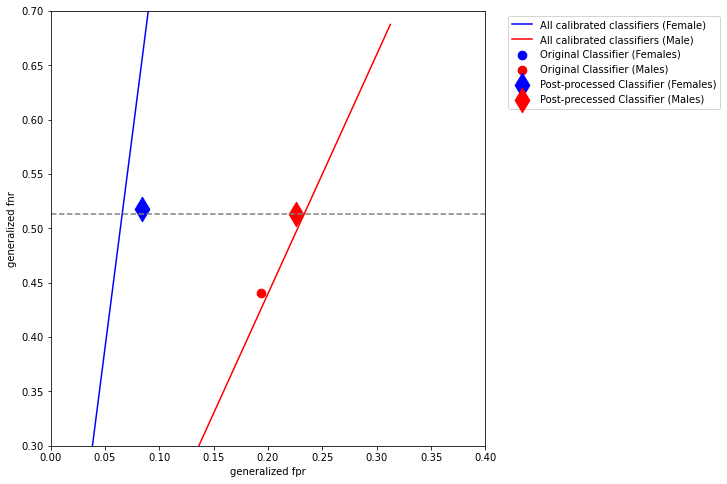

In [39]:
plt.figure(figsize=(8,8))
plt.plot([0,br[0]],[0,1-br[0]],'-b',label='All calibrated classifiers (Female)')
plt.plot([0,br[1]],[0,1-br[1]],'-r',label='All calibrated classifiers (Male)')

plt.scatter(generalized_fpr(y_test[~i],y_lr[~i]),generalized_fnr(y_test[~i],y_lr[~i]),
        300,c='b',marker='.',label='Original Classifier (Females)')

plt.scatter(generalized_fpr(y_test[i],y_lr[i]),generalized_fnr(y_test[i],y_lr[i]),
        300,c='r',marker='.',label='Original Classifier (Males)')

plt.scatter(generalized_fpr(y_test[~i],y_pred[~i]),generalized_fnr(y_test[~i],y_pred[~i]),
        300,c='b',marker='d',label='Post-processed Classifier (Females)')

plt.scatter(generalized_fpr(y_test[i],y_pred[i]),generalized_fnr(y_test[i],y_pred[i]),
        300,c='r',marker='d',label='Post-precessed Classifier (Males)')

plt.plot([0,1],[generalized_fnr(y_test,y_pred)]*2,'--',c='0.5')
plt.axis('square')
plt.xlim([0.0,0.4])
plt.ylim([0.3,0.7])
plt.xlabel('generalized fpr')
plt.ylabel('generalized fnr')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

In [25]:
difference(generalized_fnr,y_test,y_pred,prot_attr='sex')

0.004610862488743761